In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from dependencies.doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [4]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=800)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(content_basepath="../../data/content/prod",
#                              basepath_suffix="_content.csv", drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=10)

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/newest")

2017-08-28 14:11:40,300 : INFO : Loading serialized wrapper model from: trained_models/wrapper/newest
2017-08-28 14:11:40,302 : INFO : Loading all_base_vocab_docs objects
2017-08-28 14:11:50,224 : INFO : Initialized 51418 headers of 51418 for vectorization
2017-08-28 14:11:50,225 : INFO : Loading all_base_vocab_docs vectors
2017-08-28 14:13:05,041 : INFO : Loading trained Doc2Vec model
2017-08-28 14:13:05,042 : INFO : loading Doc2Vec object from trained_models/wrapper/newest/doc2vec.mod
2017-08-28 14:13:05,349 : INFO : loading docvecs recursively from trained_models/wrapper/newest/doc2vec.mod.docvecs.* with mmap=None
2017-08-28 14:13:05,350 : INFO : loading doctag_syn0 from trained_models/wrapper/newest/doc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-08-28 14:13:05,707 : INFO : loading syn1neg from trained_models/wrapper/newest/doc2vec.mod.syn1neg.npy with mmap=None
2017-08-28 14:13:06,020 : INFO : loading syn0 from trained_models/wrapper/newest/doc2vec.mod.syn0.npy with mmap=N

In [5]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_vocab_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-08-28 14:13:06,422 : INFO : Returning already inferred doc vectors of 51418 all_base_vocab_docs


In [6]:
doc_labels.describe()

count     51418
unique       16
top         eap
freq      18302
Name: y, dtype: object

In [7]:
# classifier training and eval:
from sklearn.svm import LinearSVC

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
correct_logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    logging.info("Shuffling indices")
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)

    # training
    svm_classifier = LinearSVC(C=0.1)
    
    logging.info("Fitting classifier")
    svm_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])

    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = svm_classifier.predict(doc_vectors.iloc[test_doc_indices])

    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = svm_classifier.decision_function(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(svm_classifier.classes_)

    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)), (class_actual_index)]

    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)), (class_expected_index)]

    new_logits = pd.DataFrame()
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    correct_logits = correct_logits.append(new_logits)
    
    new_wrong_ids = test_doc_indices[actual_prob == expected_prob]
    wrong_docs_ids = wrong_docs_ids.append(pd.Series(new_wrong_ids))

    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

2017-08-28 14:13:07,418 : INFO : Shuffling indices
2017-08-28 14:13:07,453 : INFO : Fitting classifier
2017-08-28 14:14:02,827 : INFO : Predicting
2017-08-28 14:14:06,420 : INFO : Probs collection
2017-08-28 14:14:10,051 : INFO : Split results:
2017-08-28 14:14:10,058 : INFO : Run accuracy: 0.893499174036
2017-08-28 14:14:10,067 : INFO : Cat accuracies:
[0.8955650929899857, 0.8834142956280361, 0.4603174603174603, 0.5555555555555556, 0.7142857142857143, 0.0, 0.3333333333333333, 0.5477941176470589, 0.4322916666666667, 0.3333333333333333, 0.8533333333333334, 0.9933020763563295, 0.9585571757482733, 0.2824427480916031, 0.5104166666666666, 0.9546571974870254]
2017-08-28 14:14:10,069 : INFO : Shuffling indices
2017-08-28 14:14:10,158 : INFO : Fitting classifier
2017-08-28 14:15:03,250 : INFO : Predicting
2017-08-28 14:15:06,730 : INFO : Probs collection
2017-08-28 14:15:10,242 : INFO : Split results:
2017-08-28 14:15:10,249 : INFO : Run accuracy: 0.89366251944
2017-08-28 14:15:10,256 : INFO :

In [8]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())

2017-08-28 14:18:18,455 : INFO : split accuracies: [0.893499174035565, 0.89366251944012443, 0.88913741126130508, 0.89269384181340594, 0.89491096623528266]
2017-08-28 14:18:18,458 : INFO : mean accuracy: 0.892780782557
2017-08-28 14:18:18,477 : INFO : categories accuracies: 
   openshift      fuse  datagrid  bpmsuite  mobileplatform  \
0   0.895565  0.883414  0.460317  0.555556        0.714286   
0   0.891273  0.874393  0.539683  0.551111        0.650000   
0   0.891117  0.881332  0.555556  0.537778        0.650000   
0   0.891117  0.876475  0.507937  0.589286        0.700000   
0   0.901146  0.886884  0.467742  0.513393        0.600000   

   softwarecollections       cdk      brms  webserver  developertoolset  \
0                  0.0  0.333333  0.547794   0.432292          0.333333   
0                  0.0  0.266667  0.547794   0.507853          0.000000   
0                  0.0  0.357143  0.533088   0.439791          0.500000   
0                  0.0  0.428571  0.538745   0.42408

In [9]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
5,softwarecollections,0.000000,5
9,developertoolset,0.166667,12
6,cdk,0.348571,72
4,mobileplatform,0.662857,101
2,datagrid,0.506247,314
14,fsw,0.493640,478
13,amq,0.359319,654
8,webserver,0.452950,956
3,bpmsuite,0.549425,1123
7,brms,0.542709,1358


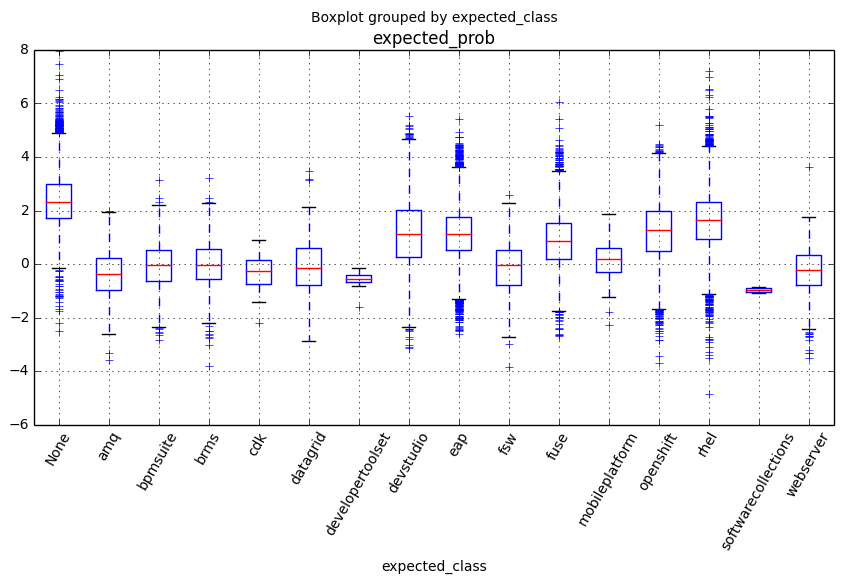

In [10]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, q50 +- 1.5*<q25, q75> in whis intervals
%matplotlib inline
import matplotlib.pyplot as plt

correct_logits.boxplot("expected_prob", by="expected_class", figsize=(10,5), rot=60)

In [11]:
# incorrect classification characteristics
wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.all_content_tagged_docs.iloc[doc_id].words)
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))

wrong_docs_len.describe()

count    45905.000000
mean       131.727285
std        437.528505
min         10.000000
25%         27.000000
50%         47.000000
75%        115.000000
max      56006.000000
dtype: float64

In [12]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.all_content_tagged_docs.iloc[doc_id].words)
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count     5513.000000
mean       158.636677
std       1155.404772
min         10.000000
25%         18.000000
50%         32.000000
75%         79.000000
max      79212.000000
dtype: float64